# **Proyecto final simulación estocástica**

# Librerías

In [ ]:
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# Caso 1: $Z^2$

### Funciones que simulan la evolución en $Z^2$:

In [ ]:

# Funciones preliminares

def en_borde(i, j, N): # para ver si X[i,j] está en algún borde
    return i == 0 or i == N-1 or j == 0 or j == N-1


def vecinos_contagiados_abiertos(v, X):#numero de vecinos contagiados caso abierto
    N = X.shape[0]
    i, j = v
    n = 0
    if i > 0 and X[i-1, j] == 1: n += 1
    if i < N-1 and X[i+1, j] == 1: n += 1
    if j > 0 and X[i, j-1] == 1: n += 1
    if j < N-1 and X[i, j+1] == 1: n += 1
    return n

def vecinos_indices_abiertos(i, j, N):#vecinos caso abierto
    out = []
    if i > 0:   out.append((i-1, j))
    if i < N-1: out.append((i+1, j))
    if j > 0:   out.append((i, j-1))
    if j < N-1: out.append((i, j+1))
    return out

def recalcula_L_local_abierto(L, X, i, j, lam, f):#se recalcula la matriz de tasas de infección tras un cambio y devuelve la suma de las tasas para no tener que recalcular
    N = X.shape[0]
    sitios = [(i, j)] + vecinos_indices_abiertos(i, j, N)
    for (y, x) in sitios:
        f -= L[y, x]
        if X[y, x] == 1:
            L[y, x] = 0.0
        else:
            L[y, x] = lam * vecinos_contagiados_abiertos((y, x), X)
        f += L[y, x]
    return f


def expandir_grilla(X, L, lam):

    N = X.shape[0]

    X_new = np.zeros((N+2, N+2), dtype=int)
    L_new = np.zeros((N+2, N+2), dtype=float)

    # Copiamos al centro
    X_new[1:N+1, 1:N+1] = X
    L_new[1:N+1, 1:N+1] = L

    # Ahora recalculamos L SOLO en el borde nuevo
    Nb = N + 2  # tamaño grande

    # --- fila superior (i = 0)
    for j in range(Nb):
        if X_new[0, j] == 0:
            L_new[0, j] = lam * vecinos_contagiados_abiertos((0, j), X_new)

    # --- fila inferior (i = Nb-1)
    for j in range(Nb):
        if X_new[Nb-1, j] == 0:
            L_new[Nb-1, j] = lam * vecinos_contagiados_abiertos((Nb-1, j), X_new)

    # --- columna izquierda (j = 0), sin esquinas (ya calculadas)
    for i in range(1, Nb-1):
        if X_new[i, 0] == 0:
            L_new[i, 0] = lam * vecinos_contagiados_abiertos((i, 0), X_new)

    # --- columna derecha (j = Nb-1)
    for i in range(1, Nb-1):
        if X_new[i, Nb-1] == 0:
            L_new[i, Nb-1] = lam * vecinos_contagiados_abiertos((i, Nb-1), X_new)

    return X_new, L_new

def contraer_grilla(X_big, L_big):
    # quita fila 0 y N+1, lo mismo con columnas
    X_old = X_big[1:-1, 1:-1].copy()
    L_old = L_big[1:-1, 1:-1].copy()
    return X_old, L_old

def contacto_abierto(X_0, lam, t_max): #devuelve lista con los tiempos y la evolución de estados para este caso.
    X_0 = X_0.copy().astype(int)
    X = [X_0] #evolución del sistema
    T = [0.0]  #tiempos de cada estado

    N = X_0.shape[0]
    L = np.zeros((N, N), dtype=float)  #tasas de infección

    #inicializamos tasas L en t=0
    f = 0.0
    for i in range(N):
        for j in range(N):
            if X_0[i, j] == 1:
                L[i, j] = 0.0
            else:
                L[i, j] = lam * vecinos_contagiados_abiertos((i, j), X_0)
            f += L[i, j]

    t = 0.0
    Xt = X_0
    r = int(Xt.sum())  # número de infectados (tasa total de recuperación)

    while t < t_max:
        l =  f + r        # tasa total del sistema (infección + recuperación)
        if l <= 0.0:
          break

        dt = np.random.exponential(scale = 1 / l)#tiempo hasta próximo evento
        t += dt
        u = np.random.random() #variable usada para decidir si desinfectar o infectar
        u1 = np.random.random() #variable usada para decidir a quien infectar o desinfectar
        x,y=0,0 #posición del vértice a cambiar


        # CASO INFECCIÓN

        if u<f/l:

          # Primero expandimos la grilla
          Xt_big, L_big = expandir_grilla(Xt, L, lam)
          Nbig = Xt_big.shape[0]

          f_big = L_big.sum()
          if f_big <= 0.0:
            continue


          sumap = 0.0
          thr = u1 * f_big
          found = False
          for i in range(Nbig):
            for j in range(Nbig):
              sumap += L_big[i, j]
              if thr <= sumap:  #elegimos el vertice i,j con probabilidad lambda_i/f
                xi,yi = i, j
                found = True
                break
            if found:
              break

          if en_borde(xi, yi, Nbig):
                # aceptamos la grilla expandida como la nueva grilla real
                Xt = Xt_big
                L = L_big
                N = Xt.shape[0]

                # si el sitio está susceptible, infectarlo
                if Xt[xi, yi] == 0:
                    Xt = Xt.copy()
                    Xt[xi, yi] = 1
                    r += 1
                    # actualizamos f partiendo de f_big (que es L_big.sum())
                    f = recalcula_L_local_abierto(L, Xt, xi, yi, lam, f_big)

          else: #ie no esta en el borde
            x_orig = xi - 1
            y_orig = yi - 1 #mapear coords originales

            if Xt[x_orig, y_orig] == 0:
                    Xt = Xt.copy()
                    Xt[x_orig, y_orig] = 1
                    r += 1
                    # Actualizamos L y f localmente en la grilla antigua
                    f = recalcula_L_local_abierto(L, Xt, x_orig, y_orig, lam, f)



        else:#desinfeccion
          if r > 0:
            c = 0
            k = int(u1*r) if int(u1*r) < r else r-1
            found = False
            Ncur = Xt.shape[0]
            for i in range(Ncur):
              for j in range(Ncur):
                if Xt[i, j] == 1:
                  if c == k: #se elige un vértice uniformemente entre los recuperados
                    x,y= i, j
                    found = True
                    break
                  c += 1
              if found:
                break


            Xt = Xt.copy()
            Xt[x, y] = 0
            r -= 1
            f = recalcula_L_local_abierto(L, Xt, x, y, lam, f)

        X.append(Xt)
        T.append(t)

    return X, T


### Animación en $Z^2$:

Guardando animación como eee.gif...
¡GIF guardado exitosamente!


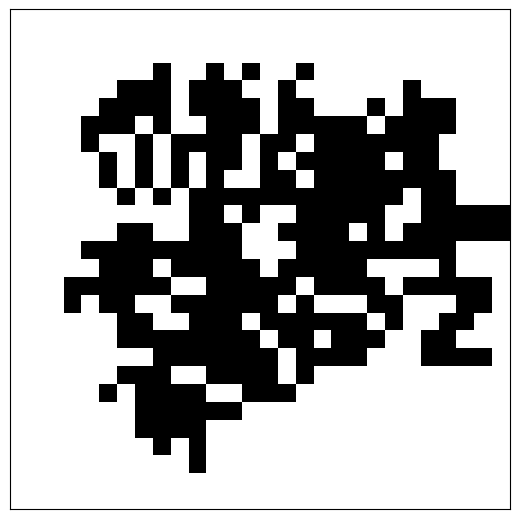

In [ ]:
def animar_contacto(X, T, delay=20, save_gif=False, filename="animaciontest.gif"):
    fig, ax = plt.subplots(figsize=(5,5))
    N = X[0].shape[0]

    def update(frame):
        ax.clear()
        ax.imshow(
            X[frame],
            cmap="gray_r",
            interpolation="nearest",
            extent=[0, N, 0, N]
        )
        ax.set_xlim(0, N)
        ax.set_ylim(0, N)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_position([0,0,1,1])  # sin bordes

    anim = animation.FuncAnimation(
        fig, update, frames=len(X),
        interval=delay, repeat=True
    )

    if save_gif:
        print(f"Guardando animación como {filename}...")
        anim.save(
            filename,
            writer='pillow',
            fps=1000/delay,
            dpi=100
        )
        print("¡GIF guardado exitosamente!")

    plt.show()
    return anim


N = 10
p_inicial = 0.05
X0 = (np.random.random((N, N)) < p_inicial).astype(int)
X, T = contacto_abierto(X0, lam=1, t_max=5)
# Crear y guardar la animación
anim = animar_contacto(
    X, T,
    delay=20,  # ms entre frames
    save_gif=True,
    filename="eee.gif"
)

### Estimación de parámetros en $Z^2$

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm




lambdas = np.arange(0.10, 2.51, 0.05)



tmax_values = (
    [30]*10 +     # 0.10 - 0.55
    [20]*8  +     # 0.60 - 0.95
    [10]*10 +     # 1.00 - 1.45
    [5]*8   +     # 1.50 - 1.85
    [3]*13        # 1.90 - 2.50
)

assert len(tmax_values) == len(lambdas), "ERROR: tmax_values no coincide con tamaño de lambdas"

n_runs = 100
delta_list = [0.1, 0.15, 0.20]
N0 = 5   # grilla inicial 5x5



# Tiempo infectado del centro


def tiempo_infectado_centro(X_hist, T_hist):
    tiempo = 0.0
    for k in range(1, len(T_hist)):
        dt = T_hist[k] - T_hist[k-1]
        Xt = X_hist[k-1]
        N = Xt.shape[0]
        c = N // 2
        tiempo += Xt[c, c] * dt
    return tiempo



# Tabla resultados


tabla = []

print("Iniciando simulaciones...\n")

for idx, lam in enumerate(lambdas):
    tmax = tmax_values[idx]
    sobreviven = 0
    mueren = 0
    fracciones = []
    infinitas_count = {d: 0 for d in delta_list}

    print(f"==== λ = {lam:.2f}, tmax = {tmax}, corridas = {n_runs} ====")

    for _ in tqdm(range(n_runs)):
        # Estado inicial
        X0 = np.zeros((N0, N0), dtype=int)
        X0[N0//2, N0//2] = 1

        # Simulación
        X_hist, T_hist = contacto_abierto(X0, lam, tmax)

        # Supervivencia
        X_final = X_hist[-1]
        if X_final.sum() > 0:
            sobreviven += 1
        else:
            mueren += 1

        # Tiempo infectado del centro
        tiempo_inf = tiempo_infectado_centro(X_hist, T_hist)
        fr = tiempo_inf / tmax
        fracciones.append(fr)

        # Criterios infinitas veces
        for d in delta_list:
            if fr >= d:
                infinitas_count[d] += 1

    # Probabilidades estimadas
    prob_sobrevive = sobreviven / n_runs
    prob_infinitas = {d: infinitas_count[d] / n_runs for d in delta_list}
    promedio_fr = np.mean(fracciones)

    tabla.append({
        "lambda": round(lam, 3),
        "tmax": tmax,
        "corridas": n_runs,
        "sobreviven": sobreviven,
        "mueren": mueren,
        "prob_supervivencia": prob_sobrevive,
        "tasa_infeccion_0": promedio_fr,
        "prob_inf_010": prob_infinitas[0.10],
        "prob_inf_015": prob_infinitas[0.15],
        "prob_inf_020": prob_infinitas[0.20],
    })

df = pd.DataFrame(tabla)
df.to_csv("tabla_resultados_Z2.csv", index=False)

print("\n--- TABLA GENERADA ---")
print(df.head())

### Gráficos:

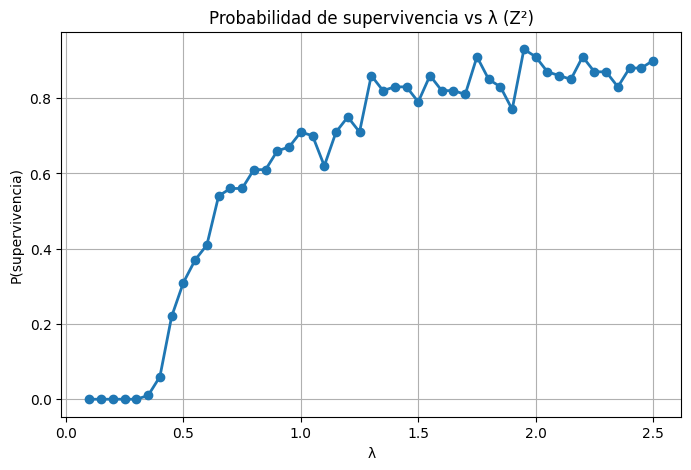

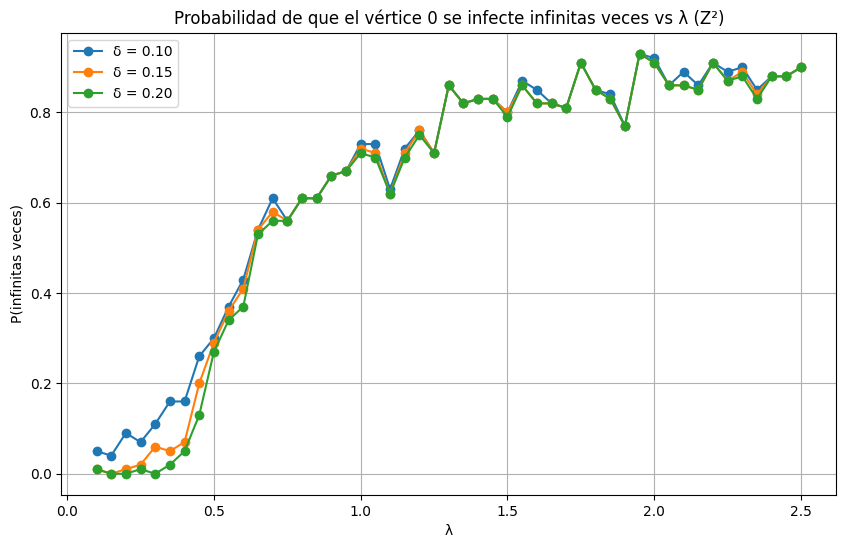

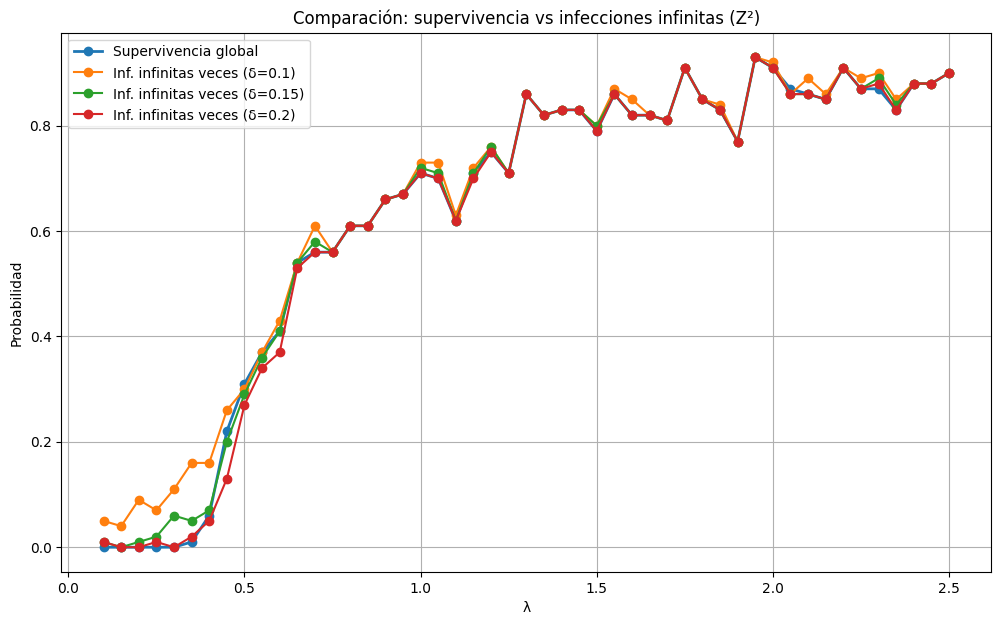

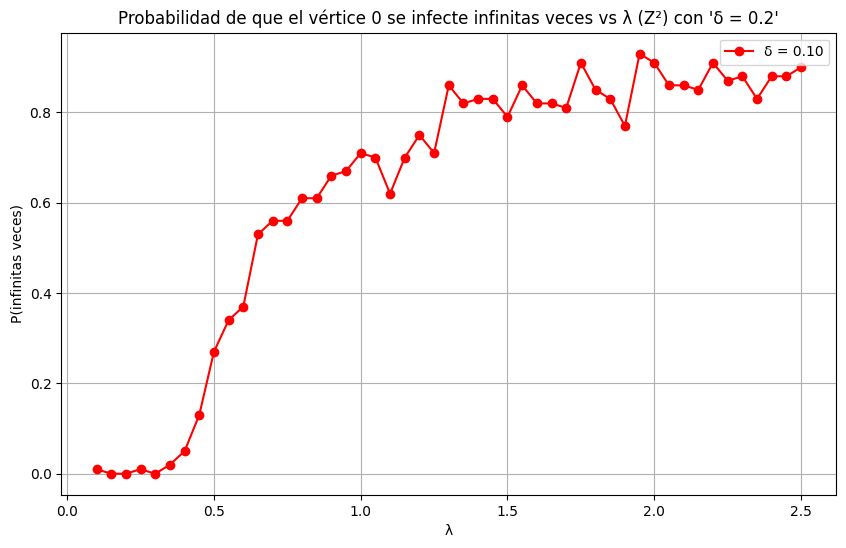

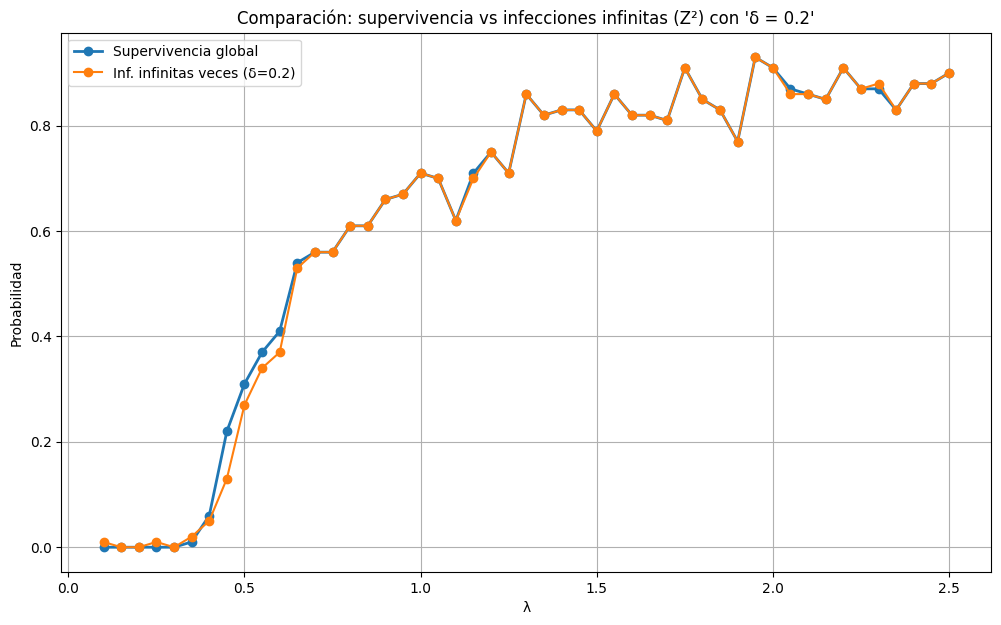

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(df["lambda"], df["prob_supervivencia"], "o-", lw=2)
plt.title("Probabilidad de supervivencia vs λ (Z²)")
plt.xlabel("λ")
plt.ylabel("P(supervivencia)")
plt.grid(True)
plt.show()



plt.figure(figsize=(10,6))
plt.plot(df["lambda"], df["prob_inf_010"], "o-", label="δ = 0.10")
plt.plot(df["lambda"], df["prob_inf_015"], "o-", label="δ = 0.15")
plt.plot(df["lambda"], df["prob_inf_020"], "o-", label="δ = 0.20")
plt.title("Probabilidad de que el vértice 0 se infecte infinitas veces vs λ (Z²)")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.legend()
plt.grid(True)
plt.show()



plt.figure(figsize=(12,7))

plt.plot(df["lambda"], df["prob_supervivencia"], "o-", lw=2, label="Supervivencia global")
plt.plot(df["lambda"], df["prob_inf_010"], "o-", label="Inf. infinitas veces (δ=0.1)")
plt.plot(df["lambda"], df["prob_inf_015"], "o-", label="Inf. infinitas veces (δ=0.15)")
plt.plot(df["lambda"], df["prob_inf_020"], "o-", label="Inf. infinitas veces (δ=0.2)")

plt.title("Comparación: supervivencia vs infecciones infinitas (Z²)")
plt.xlabel("λ")
plt.ylabel("Probabilidad")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df["lambda"], df["prob_inf_020"], "o-", color='red', label="δ = 0.10")
plt.title("Probabilidad de que el vértice 0 se infecte infinitas veces vs λ (Z²) con 'δ = 0.2'")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(12,7))

plt.plot(df["lambda"], df["prob_supervivencia"], "o-", lw=2, label="Supervivencia global")
plt.plot(df["lambda"], df["prob_inf_020"], "o-", label="Inf. infinitas veces (δ=0.2)")

plt.title("Comparación: supervivencia vs infecciones infinitas (Z²) con 'δ = 0.2'")
plt.xlabel("λ")
plt.ylabel("Probabilidad")
plt.legend()
plt.grid(True)
plt.show()

# Caso 2: $Z$

Análogo al caso anterior, sólo q ahora estamos en la recta Z. También se va expandiendo.

In [ ]:
def vecinos_indices_abiertos_1D(i, N):
    out = []
    if i > 0: out.append(i-1)
    if i < N-1: out.append(i+1)
    return out


def vecinos_contagiados_abiertos_1D(i, X):
    N = X.shape[0]
    n = 0
    if i > 0 and X[i-1] == 1: n += 1
    if i < N-1 and X[i+1] == 1: n += 1
    return n


def recalcula_L_local_abierto_1D(L, X, i, lam, f):
    N = X.shape[0]
    sitios = [i] + vecinos_indices_abiertos_1D(i, N)

    for y in sitios:
        f -= L[y]
        if X[y] == 1:
            L[y] = 0.0
        else:
            L[y] = lam * vecinos_contagiados_abiertos_1D(y, X)
        f += L[y]

    return f


def expandir_grilla_1D(X, L, lam):
    N = X.shape[0]

    # Expande en 2 (uno por cada lado)
    X_new = np.zeros(N + 2, dtype=int)
    L_new = np.zeros(N + 2, dtype=float)

    # Copia al centro
    X_new[1:N+1] = X
    L_new[1:N+1] = L

    # Recalcular L solo en los dos bordes
    # posición 0
    if X_new[0] == 0:
        L_new[0] = lam * vecinos_contagiados_abiertos_1D(0, X_new)

    # posición N+1
    if X_new[N+1] == 0:
        L_new[N+1] = lam * vecinos_contagiados_abiertos_1D(N+1, X_new)

    return X_new, L_new


def contraer_grilla_1D(X_big, L_big):
    return X_big[1:-1].copy(), L_big[1:-1].copy()


def contacto_abierto_1D(X_0, lam, t_max):
    X_0 = X_0.copy().astype(int)
    X = [X_0]
    T = [0.0]

    N = X_0.shape[0]
    L = np.zeros(N, dtype=float)

    # Inicializar tasas L
    f = 0.0
    for i in range(N):
        if X_0[i] == 1:
            L[i] = 0.0
        else:
            L[i] = lam * vecinos_contagiados_abiertos_1D(i, X_0)
        f += L[i]

    t = 0.0
    Xt = X_0
    r = int(Xt.sum())  # Infectados = tasa total de recuperación

    while t < t_max:
        l = f + r
        if l <= 0:
            break

        dt = np.random.exponential(scale=1/l)
        t += dt

        u = np.random.random()
        u1 = np.random.random()

        # --- INFECCIÓN ---
        if u < f/l:

            Xt_big, L_big = expandir_grilla_1D(Xt, L, lam)
            Nbig = Xt_big.shape[0]

            f_big = L_big.sum()
            if f_big <= 0:
                continue

            # Elegir sitio proporcional a tasa
            thr = u1 * f_big
            sumap = 0.0
            xi = None
            for i in range(Nbig):
                sumap += L_big[i]
                if sumap >= thr:
                    xi = i
                    break

            # Si se infecta en el borde => aceptamos expansión
            if xi == 0 or xi == Nbig-1:

                Xt = Xt_big
                L = L_big
                N = Xt.shape[0]

                if Xt[xi] == 0:
                    Xt = Xt.copy()
                    Xt[xi] = 1
                    r += 1
                    f = recalcula_L_local_abierto_1D(L, Xt, xi, lam, f_big)

            else:
                # Coordenada en la grilla antigua
                x_orig = xi - 1

                if Xt[x_orig] == 0:
                    Xt = Xt.copy()
                    Xt[x_orig] = 1
                    r += 1
                    f = recalcula_L_local_abierto_1D(L, Xt, x_orig, lam, f)

        # --- RECUPERACIÓN ---
        else:
            if r > 0:
                # elegir uniformemente entre infectados
                infectados = np.where(Xt == 1)[0]
                x = infectados[int(u1 * r)] if r > 1 else infectados[0]

                Xt = Xt.copy()
                Xt[x] = 0
                r -= 1
                f = recalcula_L_local_abierto_1D(L, Xt, x, lam, f)

        X.append(Xt)
        T.append(t)

    return X, T



Iniciando simulaciones...

==== λ = 0.10, tmax = 40, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 16421.33it/s]


==== λ = 0.20, tmax = 40, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 9323.99it/s]


==== λ = 0.30, tmax = 40, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 13856.95it/s]


==== λ = 0.40, tmax = 40, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 10434.21it/s]


==== λ = 0.50, tmax = 40, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 9088.38it/s]


==== λ = 0.60, tmax = 35, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 8134.42it/s]


==== λ = 0.70, tmax = 35, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 6723.47it/s]


==== λ = 0.80, tmax = 30, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 5924.01it/s]


==== λ = 0.90, tmax = 30, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 4455.25it/s]


==== λ = 1.00, tmax = 30, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 3766.23it/s]


==== λ = 1.10, tmax = 30, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 2562.86it/s]


==== λ = 1.20, tmax = 25, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 1916.07it/s]


==== λ = 1.30, tmax = 25, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 931.91it/s]


==== λ = 1.40, tmax = 25, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 597.76it/s]


==== λ = 1.50, tmax = 20, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 530.55it/s]


==== λ = 1.60, tmax = 20, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 516.94it/s]


==== λ = 1.70, tmax = 20, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 444.74it/s]


==== λ = 1.80, tmax = 15, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 558.78it/s]


==== λ = 1.90, tmax = 15, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 466.59it/s]


==== λ = 2.00, tmax = 15, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 441.16it/s]


==== λ = 2.10, tmax = 10, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 664.98it/s]


==== λ = 2.20, tmax = 10, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 595.54it/s]


==== λ = 2.30, tmax = 10, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 527.38it/s]


==== λ = 2.40, tmax = 10, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 446.53it/s]


==== λ = 2.50, tmax = 10, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 397.15it/s]


==== λ = 2.60, tmax = 8, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 377.51it/s]


==== λ = 2.70, tmax = 8, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 303.68it/s]


==== λ = 2.80, tmax = 8, corridas = 500 ====


100%|██████████| 500/500 [00:01<00:00, 485.61it/s]


==== λ = 2.90, tmax = 6, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 721.54it/s]


==== λ = 3.00, tmax = 6, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 662.68it/s]


==== λ = 3.10, tmax = 6, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 647.88it/s]


==== λ = 3.20, tmax = 5, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 751.12it/s]


==== λ = 3.30, tmax = 5, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 762.63it/s]


==== λ = 3.40, tmax = 5, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 772.21it/s]


==== λ = 3.50, tmax = 5, corridas = 500 ====


100%|██████████| 500/500 [00:00<00:00, 675.39it/s]



--- TABLA GENERADA ---
    lambda  corridas  tmax  sobreviven  mueren  prob_supervivencia  \
0      0.1       500    40           0     500               0.000   
1      0.2       500    40           0     500               0.000   
2      0.3       500    40           0     500               0.000   
3      0.4       500    40           0     500               0.000   
4      0.5       500    40           0     500               0.000   
5      0.6       500    35           0     500               0.000   
6      0.7       500    35           0     500               0.000   
7      0.8       500    30           0     500               0.000   
8      0.9       500    30           0     500               0.000   
9      1.0       500    30           1     499               0.002   
10     1.1       500    30           1     499               0.002   
11     1.2       500    25          10     490               0.020   
12     1.3       500    25          19     481               0.038

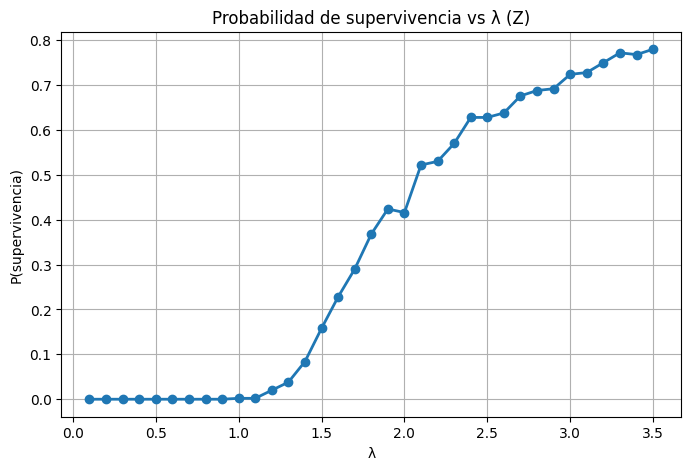

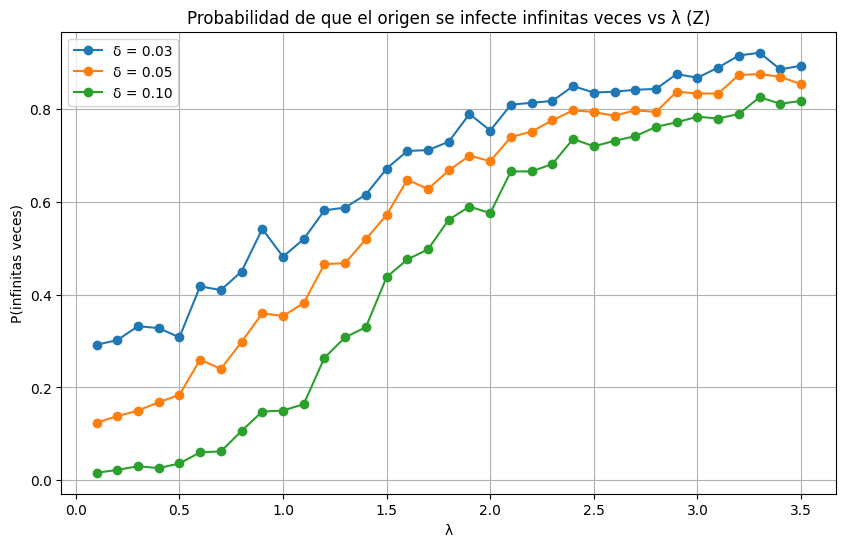

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# ============================
# CONFIGURACIÓN
# ============================

# λ = 0.1, 0.2, ..., 1.6  (16 valores)
lambdas = np.arange(0.1, 3.6, 0.1)

tmax_values = [
    40,40,40,40,40,      # λ = 0.1–0.5
    35,35,               # λ = 0.6–0.7
    30,30,30,30,         # λ = 0.8–1.1
    25,25,25,            # λ = 1.2–1.4
    20,20,20,            # λ = 1.5–1.7
    15,15,15,            # λ = 1.8–2.0
    10,10,10,10,10,      # λ = 2.1–2.5
    8,8,8,               # λ = 2.6–2.8
    6,6,6,               # λ = 2.9–3.1
    5,5,5,5              # λ = 3.2–3.5
]

n_runs = 500
delta_list = [0.2]
N0 = 5  # largo inicial del vector en Z

# ============================
# FUNCIÓN: tiempo infectado del origen (índice central)
# ============================

def tiempo_infectado_centro(X_hist, T_hist):
    tiempo = 0.0
    for k in range(1, len(T_hist)):
        dt = T_hist[k] - T_hist[k-1]
        Xt = X_hist[k-1]
        c = len(Xt) // 2  # índice central
        tiempo += Xt[c] * dt
    return tiempo

# ============================
# BUCLE PRINCIPAL
# ============================

tabla = []

print("Iniciando simulaciones...\n")

for idx, lam in enumerate(lambdas):
    tmax = tmax_values[idx]
    sobreviven = 0
    mueren = 0
    fracciones = []
    infinitas_count = {d: 0 for d in delta_list}

    print(f"==== λ = {lam:.2f}, tmax = {tmax}, corridas = {n_runs} ====")

    for _ in tqdm(range(n_runs)):
        # Estado inicial en Z (1D)
        X0 = np.zeros(N0, dtype=int)
        X0[N0//2] = 1  # infectamos al origen

        # Simulación
        X_hist, T_hist = contacto_abierto_1D(X0, lam, tmax)

        # Supervivencia global
        X_final = X_hist[-1]
        if X_final.sum() > 0:
            sobreviven += 1
        else:
            mueren += 1

        # Fracción de tiempo infectado del origen
        tiempo_inf = tiempo_infectado_centro(X_hist, T_hist)
        fr = tiempo_inf / tmax
        fracciones.append(fr)

        # “infinitas veces”
        for d in delta_list:
            if fr >= d:
                infinitas_count[d] += 1

    # Resultados para este λ
    fila = {
        "lambda": round(lam, 2),
        "corridas": n_runs,
        "tmax": tmax,
        "sobreviven": sobreviven,
        "mueren": mueren,
        "prob_supervivencia": sobreviven / n_runs,
        "tasa_infeccion_0": np.mean(fracciones),
        "prob_inf_003": infinitas_count[0.03] / n_runs,
        "prob_inf_005": infinitas_count[0.05] / n_runs,
        "prob_inf_010": infinitas_count[0.10] / n_runs,
    }

    tabla.append(fila)

df = pd.DataFrame(tabla)
df.to_csv("tabla_resultados_Z.csv", index=False)

print("\n--- TABLA GENERADA ---")
print(df)

# ============================
# GRÁFICOS
# ============================

plt.figure(figsize=(8,5))
plt.plot(df["lambda"], df["prob_supervivencia"], "o-", lw=2)
plt.title("Probabilidad de supervivencia vs λ (Z)")
plt.xlabel("λ")
plt.ylabel("P(supervivencia)")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,6))
plt.plot(df["lambda"], df["prob_inf_003"], "o-", label="δ = 0.03")
plt.plot(df["lambda"], df["prob_inf_005"], "o-", label="δ = 0.05")
plt.plot(df["lambda"], df["prob_inf_010"], "o-", label="δ = 0.10")
plt.title("Probabilidad de que el origen se infecte infinitas veces vs λ (Z)")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.legend()
plt.grid(True)
plt.show()


Guardando 1D.gif...
Listo!


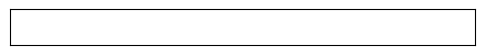

In [ ]:
def animar_contacto_1D(X, T, delay=30, save_gif=False, filename="contacto1D.gif"):
    fig, ax = plt.subplots(figsize=(6,2))

    def update(frame):
        ax.clear()

        # Replicamos la fila para que tenga altura (10 píxeles)
        row = np.tile(X[frame], (2, 1))

        ax.imshow(
            row,
            cmap="gray_r",
            interpolation="nearest",
            aspect="equal"
        )
        ax.set_yticks([])
        ax.set_xticks([])

    anim = animation.FuncAnimation(fig, update, frames=len(X), interval=delay)

    if save_gif:
        print(f"Guardando {filename}...")
        anim.save(filename, writer="pillow", fps=1000//delay)
        print("Listo!")

    plt.show()
    return anim


N = 20
p_inicial = 0.3
X0 = (np.random.random(N) < p_inicial).astype(int)

X, T = contacto_abierto_1D(X0, lam=1.5, t_max=30)

anim = animar_contacto_1D(X, T, save_gif=True, filename="1D.gif")



Nota: Las imágenes las estoy guardando en archivos pero se vean sobreescribiendo si no se les cambia nombre. Hay q ponerle nombre a lo sejes y blabla

# Caso 3: Árbol $3$-regular.

Ya acá lo hice de dos maneras. Ambas son similares a $Z$ y $Z^2$ en el sentido de que si algún nodo quiere contagiar a un hijo "inexistente" y sucede la infección, entonces el árbol se expande y el hijo es contagiado.



1.   El árbol se expande creando sólo TRES HIJOS a partir del padre que contagia al hijo "inexistente". (Ver función expandir_solo). De está forma el árbol crece de una manera más controlada y no se satura en nodos rápido.

2.   El árbol se expande todo un nivel nuevo. Esto produce que se generen demasiados nodos en cada expansión y se sature todo muy rápido.


Nota: acá se parte infectando SÓLO al primer nodo. Si se cambia entonces hay q cambiar el código.

In [ ]:
import numpy as np
import random
from collections import defaultdict
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def build_3_regular_tree(R):
    adj = defaultdict(list)
    parent = {0: None}
    frontier = [0]
    next_id = 1

    for _ in range(R):
        new_frontier = []
        for v in frontier:
            for _ in range(3 - len(adj[v])):
                u = next_id
                next_id += 1
                adj[v].append(u)
                adj[u].append(v)
                parent[u] = v
                new_frontier.append(u)
        frontier = new_frontier

    N = next_id
    X = np.zeros(N, dtype=int)
    L = np.zeros(N, dtype=float)
    return X, L, adj

def vecinos_contagiados(v, X, adj):
    return sum(X[u] == 1 for u in adj[v])

def expandir_solo(v, X, L, adj, lam, N_MAX):
    N_old = len(X)
    faltan = 3 - len(adj[v])

    if faltan <= 0:
        return X, L, adj

    if N_old + faltan > N_MAX:
        faltan = N_MAX - N_old
        if faltan <= 0:
            return X, L, adj

    adj_new = {k: list(adj[k]) for k in adj}
    X_list = list(X)
    L_list = list(L)

    next_id = N_old

    for _ in range(faltan):
        u = next_id
        next_id += 1
        adj_new[v].append(u)
        adj_new[u] = [v]
        X_list.append(0)
        L_list.append(lam if X[v] == 1 else 0.0)

    X_new = np.array(X_list, dtype=int)
    L_new = np.array(L_list, dtype=float)

    # Recalcular tasas para los nuevos nodos y el nodo v
    for u in adj_new[v]:
        L_new[u] = lam * sum(X_new[w] == 1 for w in adj_new[u])

    L_new[v] = lam * sum(X_new[w] == 1 for w in adj_new[v])

    return X_new, L_new, adj_new

def sim_contact_process(Tmax, lam, R, N_MAX=500):
    X, L, adj = build_3_regular_tree(R)

    X[0] = 1
    for u in adj[0]:
        L[u] = lam

    history = []
    t = 0.0

    while t < Tmax:
        history.append((t, X.copy(), dict(adj)))

        # CORRECCIÓN 1: Calcular r (número de infectados) en cada iteración
        r = int(X.sum())
        infect_rate = np.sum(L)
        Lambda = r + infect_rate

        if Lambda == 0:
            break

        dt = np.random.exponential(1 / Lambda)
        t += dt

        u = random.random()
        u1 = random.random()

        if u < infect_rate / Lambda:
            # ----- EVENTO DE INFECCIÓN -----
            cum = 0.0
            thr = u1 * infect_rate
            for v in range(len(X)):
                if X[v] == 0:
                    cum += L[v]
                    if cum >= thr:
                        # Infección
                        X[v] = 1
                        L[v] = 0.0

                        # Expansión antes de actualizar tasas
                        if len(adj[v]) < 3:
                            X, L, adj = expandir_solo(v, X, L, adj, lam, N_MAX)

                        # Actualizar tasas de todos los vecinos
                        for u in adj[v]:
                            if X[u] == 0:
                                L[u] = lam * vecinos_contagiados(u, X, adj)
                        break

        else:
            # ----- EVENTO DE RECUPERACIÓN -----
            if r > 0:
                k = int(u1 * r)
                if k >= r:
                    k = r - 1

                # Incrementar cum ANTES de comparar
                cum = 0
                for v in range(len(X)):
                    if X[v] == 1:
                        if cum == k:
                            # Recuperación de v
                            X[v] = 0
                            L[v] = lam * vecinos_contagiados(v, X, adj)

                            # Actualizar tasas de sus vecinos
                            for u in adj[v]:
                                if X[u] == 0:
                                    L[u] = lam * vecinos_contagiados(u, X, adj)
                            break
                        cum += 1

    history.append((t, X.copy(), dict(adj)))
    return history





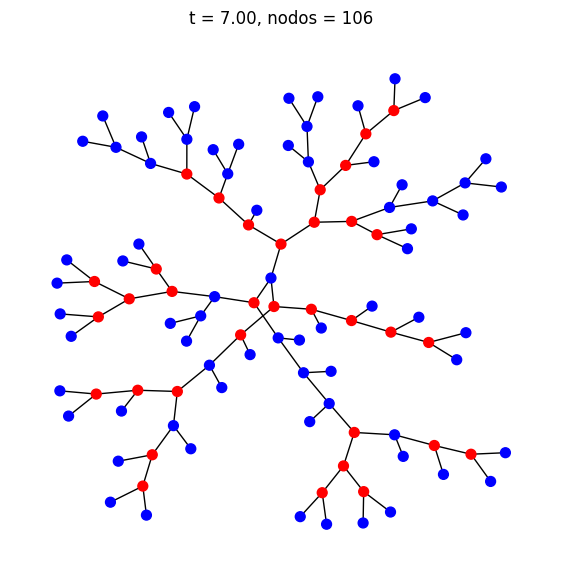

In [ ]:
# Simulación
history = sim_contact_process(Tmax=7, lam=0.9, R=2, N_MAX=500)

fig, ax = plt.subplots(figsize=(7,7))

def update(frame):
    ax.clear()
    t, X, adj = history[frame]

    G = nx.Graph()
    for v in adj:
        for u in adj[v]:
            G.add_edge(v, u)

    colors = ['red' if X[v] == 1 else 'blue' for v in G.nodes()]
    pos = nx.kamada_kawai_layout(G)

    nx.draw(G, pos, node_color=colors, node_size=50, ax=ax)
    ax.set_title(f"t = {t:.2f}, nodos = {len(G.nodes())}")

ani = FuncAnimation(fig, update, frames=len(history), interval=200)

ani.save("pruebaarbol.gif", writer="pillow")

plt.show()

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm

# ==============================
# Definir los lambdas
# ==============================
lambdas = np.round(np.arange(0.05, 2.55, 0.05), 2)

# ==============================
# Asignar tmax decreciente
# (puedes editar esta tabla)
# ==============================
tmax_values = []
for lam in lambdas:
    if lam <= 0.50:
        tmax_values.append(30)
    elif lam <= 0.8:
        tmax_values.append(20)
    elif lam <= 1.00:
        tmax_values.append(15)
    elif lam <= 1.5:
        tmax_values.append(10)
    elif lam <= 1.80:
        tmax_values.append(5)
    else:
        tmax_values.append(3)

# Número de corridas
n_runs = 100

# ==============================
# Función: tiempo infectado del nodo 0
# ==============================
def tiempo_infectado_nodo0(history):
    """
    history es la salida de sim_contact_process:
    history[k] = (t, X, adj)
    """
    tiempo = 0.0
    for k in range(1, len(history)):
        t_prev = history[k-1][0]
        t_curr = history[k][0]
        X_prev = history[k-1][1]

        dt = t_curr - t_prev
        tiempo += X_prev[0] * dt  # nodo 0 infectado?
    return tiempo

# ==============================
# Bucle principal
# ==============================
tabla = []

print("Iniciando simulaciones...\n")

for idx, lam in enumerate(lambdas):
    tmax = tmax_values[idx]

    print(f"=== λ = {lam:.2f}, tmax = {tmax}, corridas = {n_runs} ===")

    for _ in tqdm(range(n_runs)):

        # Correr simulación
        history = sim_contact_process(tmax, lam, R=2, N_MAX=700)

        X_final = history[-1][1]
        infectados_final = int(X_final.sum())
        N_final = len(X_final)
        sanos_final = N_final - infectados_final

        # 1 si sobrevive, 0 si muere completamente
        sobreviven = 1 if infectados_final > 0 else 0

        # Tiempo infectado del nodo 0
        tiempo0 = tiempo_infectado_nodo0(history)

        fila = {
            "lambda": lam,
            "tmax": tmax,
            "infectados_final": infectados_final,
            "sanos_final": sanos_final,
            "sobrevive_final": sobreviven,
            "tiempo_infectado_nodo0": tiempo0
        }
        tabla.append(fila)

# ==============================
# Guardar resultados
# ==============================
df = pd.DataFrame(tabla)
df.to_csv("resultados_arbol_3_regular.csv", index=False)

print("\n--- TABLA GENERADA ---")
print(df.head())
print("\nArchivo guardado como resultados_arbol_3_regular.csv")


Iniciando simulaciones...

=== λ = 0.05, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 9015.16it/s]


=== λ = 0.10, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 7938.95it/s]


=== λ = 0.15, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 5703.20it/s]


=== λ = 0.20, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 6039.05it/s]


=== λ = 0.25, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 1962.19it/s]


=== λ = 0.30, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 3681.41it/s]


=== λ = 0.35, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 2684.05it/s]


=== λ = 0.40, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 2120.01it/s]


=== λ = 0.45, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 780.13it/s]


=== λ = 0.50, tmax = 30, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 272.03it/s]


=== λ = 0.55, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:00<00:00, 120.65it/s]


=== λ = 0.60, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:02<00:00, 35.57it/s]


=== λ = 0.65, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:12<00:00,  8.21it/s]


=== λ = 0.70, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:22<00:00,  4.36it/s]


=== λ = 0.75, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:36<00:00,  2.75it/s]


=== λ = 0.80, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:36<00:00,  2.74it/s]


=== λ = 0.85, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [00:51<00:00,  1.93it/s]


=== λ = 0.90, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [01:03<00:00,  1.57it/s]


=== λ = 0.95, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [01:20<00:00,  1.24it/s]


=== λ = 1.00, tmax = 20, corridas = 100 ===


100%|██████████| 100/100 [01:28<00:00,  1.14it/s]


=== λ = 1.05, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [00:56<00:00,  1.77it/s]


=== λ = 1.10, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


=== λ = 1.15, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:09<00:00,  1.45it/s]


=== λ = 1.20, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:17<00:00,  1.29it/s]


=== λ = 1.25, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


=== λ = 1.30, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


=== λ = 1.35, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


=== λ = 1.40, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


=== λ = 1.45, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:47<00:00,  1.07s/it]


=== λ = 1.50, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:59<00:00,  1.20s/it]


=== λ = 1.55, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [01:58<00:00,  1.18s/it]


=== λ = 1.60, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [02:04<00:00,  1.24s/it]


=== λ = 1.65, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]


=== λ = 1.70, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [02:25<00:00,  1.46s/it]


=== λ = 1.75, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [02:29<00:00,  1.49s/it]


=== λ = 1.80, tmax = 10, corridas = 100 ===


100%|██████████| 100/100 [02:24<00:00,  1.45s/it]


=== λ = 1.85, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:22<00:00,  1.22it/s]


=== λ = 1.90, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:27<00:00,  1.15it/s]


=== λ = 1.95, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:25<00:00,  1.17it/s]


=== λ = 2.00, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


=== λ = 2.05, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:30<00:00,  1.10it/s]


=== λ = 2.10, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:38<00:00,  1.01it/s]


=== λ = 2.15, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:45<00:00,  1.06s/it]


=== λ = 2.20, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


=== λ = 2.25, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:41<00:00,  1.01s/it]


=== λ = 2.30, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:57<00:00,  1.18s/it]


=== λ = 2.35, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [01:55<00:00,  1.15s/it]


=== λ = 2.40, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [02:01<00:00,  1.22s/it]


=== λ = 2.45, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [02:04<00:00,  1.25s/it]


=== λ = 2.50, tmax = 5, corridas = 100 ===


100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


--- TABLA GENERADA ---
   lambda  tmax  infectados_final  sanos_final  sobrevive_final  \
0    0.05    30                 0           10                0   
1    0.05    30                 0           10                0   
2    0.05    30                 0           10                0   
3    0.05    30                 0           10                0   
4    0.05    30                 0           10                0   

   tiempo_infectado_nodo0  
0                0.868692  
1                1.836760  
2                1.928084  
3                0.171649  
4                1.192079  

Archivo guardado como resultados_arbol_3_regular.csv


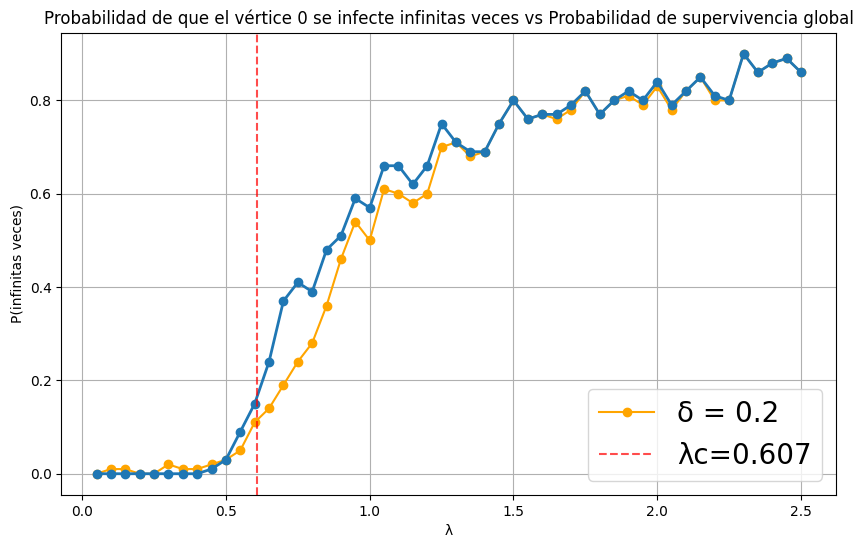

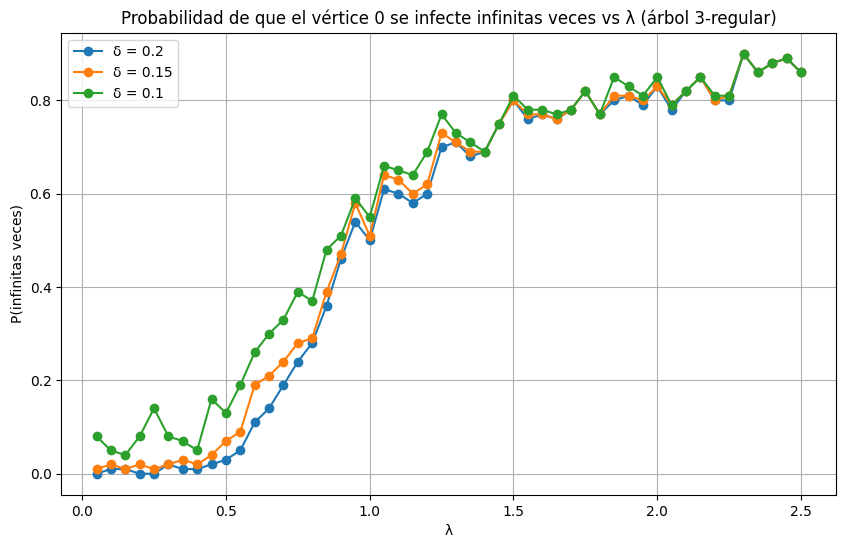

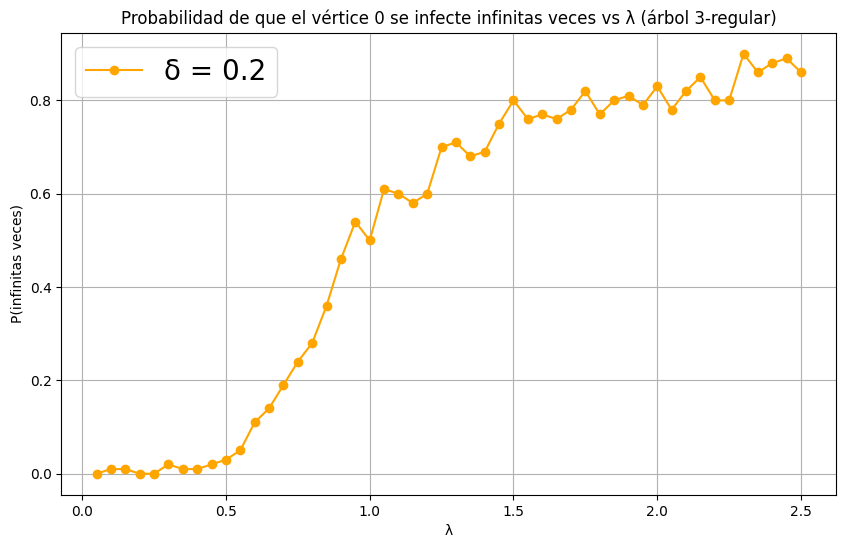

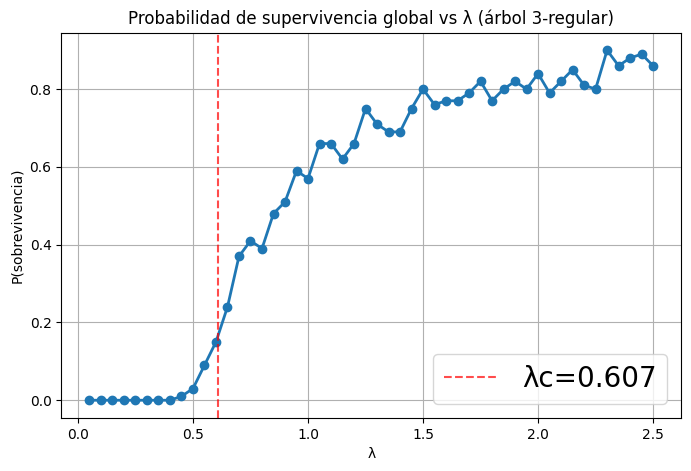

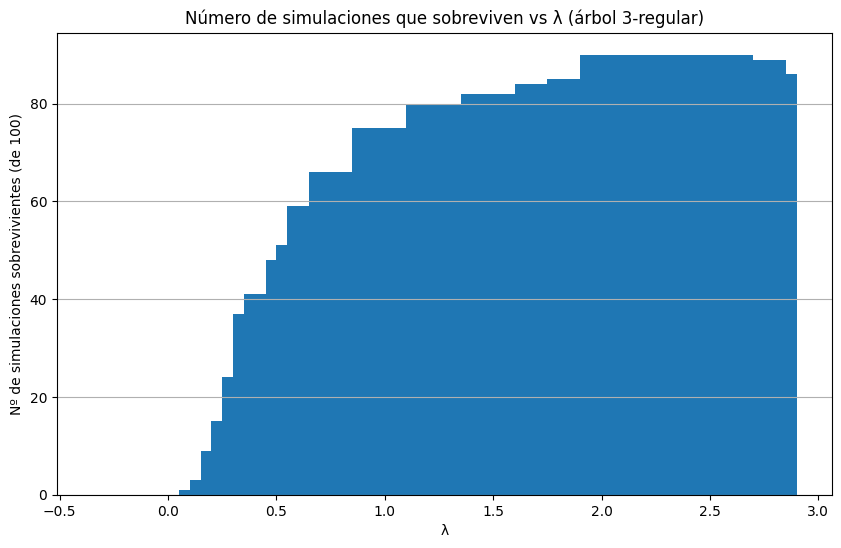

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ============================
# Cargar datos
# ============================

df = pd.read_csv("resultados_arbol_3_regular.csv")

# ============================
# Calcular fracción infectado nodo 0
# ============================

df["fraccion_0"] = df["tiempo_infectado_nodo0"] / df["tmax"]

# ============================
# Definir deltas
# ============================

delta_list = [0.2, 0.15, 0.10]

# Diccionarios para almacenar probabilidades
prob_inf = {d: [] for d in delta_list}
lambda_vals = sorted(df["lambda"].unique())

# ============================
# Calcular probabilidades por lambda
# ============================

for lam in lambda_vals:
    sub = df[df["lambda"] == lam]

    for d in delta_list:
        p = np.mean(sub["fraccion_0"] >= d)
        prob_inf[d].append(p)

# ============================
# Calcular supervivencia global
# ============================

prob_sobrevive = []
for lam in lambda_vals:
    sub = df[df["lambda"] == lam]
    p = np.mean(sub["sobrevive_final"])
    prob_sobrevive.append(p)

# ============================
# Comparación
# ============================

plt.figure(figsize=(10,6))
plt.plot(lambda_vals, prob_inf[0.2], "o-", label=f"δ = {0.2}",color='orange')
plt.plot(lambda_vals, prob_sobrevive, "o-", lw=2)
plt.axvline(x=0.607, color='red', linestyle='--', alpha=0.7, label='λc=0.607')

plt.title("Probabilidad de que el vértice 0 se infecte infinitas veces vs Probabilidad de supervivencia global")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.grid(True)
plt.legend(fontsize=20)
plt.show()

# ============================
# Graficar probabilidad de infección infinita
# ============================

plt.figure(figsize=(10,6))
for d in delta_list:
    plt.plot(lambda_vals, prob_inf[d], "o-", label=f"δ = {d}")

plt.title("Probabilidad de que el vértice 0 se infecte infinitas veces vs λ (árbol 3-regular)")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.grid(True)
plt.legend()
plt.show()

# ============================
# Graficar probabilidad de infección infinita delta=0.2
# ============================

plt.figure(figsize=(10,6))
plt.plot(lambda_vals, prob_inf[0.2], "o-", label=f"δ = {0.2}", color='orange')

plt.title("Probabilidad de que el vértice 0 se infecte infinitas veces vs λ (árbol 3-regular)")
plt.xlabel("λ")
plt.ylabel("P(infinitas veces)")
plt.grid(True)
plt.legend(fontsize=20)
plt.show()

# ============================
# Graficar probabilidad de supervivencia global
# ============================

plt.figure(figsize=(8,5))
plt.plot(lambda_vals, prob_sobrevive, "o-", lw=2)
plt.axvline(x=0.607, color='red', linestyle='--', alpha=0.7, label='λc=0.607')
plt.title("Probabilidad de supervivencia global vs λ (árbol 3-regular)")
plt.xlabel("λ")
plt.ylabel("P(sobrevivencia)")
plt.grid(True)
plt.legend(fontsize=20)
plt.show()


# ============================
# Graficar CUÁNTAS simulaciones sobreviven por λ
# ============================

survivors_count = []
for lam in lambda_vals:
    sub = df[df["lambda"] == lam]
    survivors_count.append(sub["sobrevive_final"].sum())

plt.figure(figsize=(10,6))
plt.bar(lambda_vals, survivors_count)
plt.title("Número de simulaciones que sobreviven vs λ (árbol 3-regular)")
plt.xlabel("λ")
plt.ylabel("Nº de simulaciones sobrevivientes (de 100)")
plt.grid(axis="y")
plt.show()
